# Hisat2, Stringtie, Rsubread
### Ира Макарова
### декабрь 2022



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
!conda install -y -c bioconda hisat2

In [ ]:
!conda install -y -c bioconda samtools

In [ ]:
!conda install -c "bioconda/label/cf201901" stringtie

In [ ]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

## Картирование образцов при помощи hisat2

In [ ]:
!mkdir index
!mkdir bams
!mkdir transcripts
!mkdir bin
%cd index

In [ ]:
# Фаста
!wget http://ftp.ensembl.org/pub/release-107/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.chromosome.19.fa.gz

--2022-12-23 15:25:08--  http://ftp.ensembl.org/pub/release-107/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.chromosome.19.fa.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.139
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17732438 (17M) [application/x-gzip]
Saving to: ‘Mus_musculus.GRCm39.dna.chromosome.19.fa.gz’

Mus_musculus.GRCm39 100%[===================>]  16.91M   462KB/s    in 38s     

2022-12-23 15:25:47 (453 KB/s) - ‘Mus_musculus.GRCm39.dna.chromosome.19.fa.gz’ saved [17732438/17732438]



In [ ]:
# Аннотация
!wget http://ftp.ensembl.org/pub/release-107/gtf/mus_musculus/Mus_musculus.GRCm39.107.chr.gtf.gz

--2022-12-23 15:26:53--  http://ftp.ensembl.org/pub/release-107/gtf/mus_musculus/Mus_musculus.GRCm39.107.chr.gtf.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.139
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31854002 (30M) [application/x-gzip]
Saving to: ‘Mus_musculus.GRCm39.107.chr.gtf.gz’

Mus_musculus.GRCm39 100%[===================>]  30.38M   451KB/s    in 69s     

2022-12-23 15:28:03 (450 KB/s) - ‘Mus_musculus.GRCm39.107.chr.gtf.gz’ saved [31854002/31854002]



In [ ]:
# Разархивируем
!gunzip ./*
!ls -lh

gzip: ./Mus_musculus.GRCm39.107.chr.gtf: unknown suffix -- ignored
total 891M
-rw-r--r-- 1 root root 831M Jun  4  2022 Mus_musculus.GRCm39.107.chr.gtf
-rw-r--r-- 1 root root  60M Jun  4  2022 Mus_musculus.GRCm39.dna.chromosome.19.fa


In [ ]:
# 19 хромосома
!grep -P '^19\t' Mus_musculus.GRCm39.107.chr.gtf > Mus_musculus.GRCm39.107.chr19.gtf

In [ ]:
# Строим индекс (без сайтов, аннотацию будем использовать на следующем шаге)
!hisat2-build Mus_musculus.GRCm39.dna.chromosome.19.fa Mus_musculus.GRCm39.dna.chromosome.19

Settings:
  Output files: "Mus_musculus.GRCm39.dna.chromosome.19.*.ht2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Local offset rate: 3 (one in 8)
  Local fTable chars: 6
  Local sequence length: 57344
  Local sequence overlap between two consecutive indexes: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  Mus_musculus.GRCm39.dna.chromosome.19.fa
Reading reference sizes
  Time reading reference sizes: 00:00:01
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
  Time to read SNPs and splice sites: 00:00:00
Using parameters --bmax 10916251 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 109

In [ ]:
%cd bams

/content/bams


In [ ]:
index = '/content/index/Mus_musculus.GRCm39.dna.chromosome.19'
path = '/content/drive/MyDrive/NGS/01.rna'

In [ ]:
# Картируем с softcliping, так как по итогам первого практикума выяснилось, что есть 3 образца с долей картируемых ридов менее 90 из-за не очень высокого качества в начале
my_samples = ['B14.5', 'B15.5', 'B17.5', 'B20', 'B34',
              'C14.5', 'C15.5', 'C17.5', 'C20', 'C34']
for sample in my_samples:
  !hisat2 --summary-file $sample\.log --no-unal -x $index -U $path/$sample\.fq | samtools view -Sb - > $sample\.bam
# Все хорошо откартировалось

599672 reads; of these:
  599672 (100.00%) were unpaired; of these:
    22954 (3.83%) aligned 0 times
    564666 (94.16%) aligned exactly 1 time
    12052 (2.01%) aligned >1 times
96.17% overall alignment rate
599345 reads; of these:
  599345 (100.00%) were unpaired; of these:
    41854 (6.98%) aligned 0 times
    545921 (91.09%) aligned exactly 1 time
    11570 (1.93%) aligned >1 times
93.02% overall alignment rate
600006 reads; of these:
  600006 (100.00%) were unpaired; of these:
    40749 (6.79%) aligned 0 times
    549434 (91.57%) aligned exactly 1 time
    9823 (1.64%) aligned >1 times
93.21% overall alignment rate
599777 reads; of these:
  599777 (100.00%) were unpaired; of these:
    28007 (4.67%) aligned 0 times
    561622 (93.64%) aligned exactly 1 time
    10148 (1.69%) aligned >1 times
95.33% overall alignment rate
599683 reads; of these:
  599683 (100.00%) were unpaired; of these:
    30240 (5.04%) aligned 0 times
    561254 (93.59%) aligned exactly 1 time
    8189 (1.37%)

## Сборка транскриптов при помощи stringtie для каждого образца, используя аннотацию из ensembl (-G)

In [ ]:
ann = '/content/index/Mus_musculus.GRCm39.107.chr19.gtf'
path_b = '/content/bams'
path_tr = '/content/transcripts'

In [ ]:
# Сортируем bam файлы по геномным координатам
for sample in my_samples:
  !samtools sort -m 500M -o $path_b/$sample\.s.bam $path_b/$sample\.bam

In [ ]:
# Создаем аннотацию для каждого образца
for sample in my_samples:
  !stringtie $path_b/$sample\.s.bam -o $path_tr/$sample\.gtf -G $ann

In [ ]:
# Соединяем вместе
!ls -1 $path_tr/*gtf > $path_tr/gtf.list #list of gtf files
!stringtie --merge $path_tr/gtf.list -G  $ann -o $path_tr/merged.gtf

## Картирование с использованием новой аннотации

In [ ]:
# Достаем координаты сайтов сплайсинга и экзонов
!hisat2_extract_splice_sites.py $path_tr/merged.gtf > $path_tr/ss
!hisat2_extract_exons.py $path_tr/merged.gtf > $path_tr/exons

In [ ]:
# Переделываем индексацию
!hisat2-build --ss $path_tr/ss --exon $path_tr/exons Mus_musculus.GRCm39.dna.chromosome.19.fa $path_tr/index

Settings:
  Output files: "/content/transcripts/index.*.ht2"
  Line rate: 7 (line is 128 bytes)
  Lines per side: 1 (side is 128 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Local offset rate: 3 (one in 8)
  Local fTable chars: 6
  Local sequence length: 57344
  Local sequence overlap between two consecutive indexes: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  Mus_musculus.GRCm39.dna.chromosome.19.fa
Reading reference sizes
  Time reading reference sizes: 00:00:01
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:01
  Time to read SNPs and splice sites: 00:00:00
Generation 0 (58229944 -> 58229944 nodes, 0 ranks)
COUNTED NEW NODES: 0
COUNTED TEMP NODES: 0
RESIZED NODES: 1
RESIZED NODES: 0
MADE NEW NODES: 0
Gene

In [ ]:
for sample in my_samples:
  !hisat2 --summary-file $path_b/$sample\.log --no-softclip --no-unal -x $path_tr/index -U $path/$sample\.fq | samtools view -Sb - > $path_tr/$sample\.tr.bam
# есть два образца, доля картирующихся ридов по которым, 87%, сделаем с softcliping

599672 reads; of these:
  599672 (100.00%) were unpaired; of these:
    46782 (7.80%) aligned 0 times
    540796 (90.18%) aligned exactly 1 time
    12094 (2.02%) aligned >1 times
92.20% overall alignment rate
599345 reads; of these:
  599345 (100.00%) were unpaired; of these:
    70486 (11.76%) aligned 0 times
    517424 (86.33%) aligned exactly 1 time
    11435 (1.91%) aligned >1 times
88.24% overall alignment rate
600006 reads; of these:
  600006 (100.00%) were unpaired; of these:
    74862 (12.48%) aligned 0 times
    515592 (85.93%) aligned exactly 1 time
    9552 (1.59%) aligned >1 times
87.52% overall alignment rate
599777 reads; of these:
  599777 (100.00%) were unpaired; of these:
    50875 (8.48%) aligned 0 times
    538652 (89.81%) aligned exactly 1 time
    10250 (1.71%) aligned >1 times
91.52% overall alignment rate
599683 reads; of these:
  599683 (100.00%) were unpaired; of these:
    51646 (8.61%) aligned 0 times
    539758 (90.01%) aligned exactly 1 time
    8279 (1.38

In [ ]:
# Картируем c softcliping
for sample in my_samples:
  !hisat2 --summary-file $path_b/$sample\.log --no-unal -x $path_tr/index -U $path/$sample\.fq | samtools view -Sb - > $path_tr/$sample\.tr.bam
# все в порядке (93-96%)

599672 reads; of these:
  599672 (100.00%) were unpaired; of these:
    22786 (3.80%) aligned 0 times
    564343 (94.11%) aligned exactly 1 time
    12543 (2.09%) aligned >1 times
96.20% overall alignment rate
599345 reads; of these:
  599345 (100.00%) were unpaired; of these:
    41492 (6.92%) aligned 0 times
    545920 (91.09%) aligned exactly 1 time
    11933 (1.99%) aligned >1 times
93.08% overall alignment rate
600006 reads; of these:
  600006 (100.00%) were unpaired; of these:
    40546 (6.76%) aligned 0 times
    549262 (91.54%) aligned exactly 1 time
    10198 (1.70%) aligned >1 times
93.24% overall alignment rate
599777 reads; of these:
  599777 (100.00%) were unpaired; of these:
    27810 (4.64%) aligned 0 times
    561404 (93.60%) aligned exactly 1 time
    10563 (1.76%) aligned >1 times
95.36% overall alignment rate
599683 reads; of these:
  599683 (100.00%) were unpaired; of these:
    30063 (5.01%) aligned 0 times
    561058 (93.56%) aligned exactly 1 time
    8562 (1.43%

In [ ]:
# Сортируем и индексируем bam
for sample in my_samples:
  !samtools sort -o $path_tr/$sample\.tr.s.bam $path_tr/$sample\.tr.bam
  !samtools index $path_tr/$sample\.tr.s.bam


## Оценка экспрессии генов в каждом образце при помощи Rsubread

In [ ]:
# Rmagic
from rpy2 import robjects as ro
#from rpy2.robjects.packages import importr
#from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
%load_ext rpy2.ipython

In [ ]:
# Устанавливаем Rsubread
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("Rsubread")

library(Rsubread)

In [ ]:
# Устанавливаем edgeR
%%R
BiocManager::install("edgeR")

library(edgeR)

R[write to console]: 'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


R[write to console]: Bioconductor version 3.16 (BiocManager 1.30.19), R 4.2.2 Patched (2022-11-10
  r83330)

R[write to console]: Installing package(s) 'edgeR'

R[write to console]: also installing the dependencies ‘limma’, ‘locfit’


R[write to console]: trying URL 'https://bioconductor.org/packages/3.16/bioc/src/contrib/limma_3.54.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1516770 bytes (1.4 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console

In [ ]:
%cd ../transcripts

/content/transcripts


In [ ]:
# Rsubread
%%R
bam_files = list.files('/content/transcripts',
                       pattern="*.tr.s.bam$",
                       full.names=TRUE)
counts = featureCounts(files=bam_files,
                       annot.ext="merged.gtf",
                       isGTFAnnotationFile=TRUE)


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
       Rsubread 2.12.2

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 10 BAM files                                     ||
||                                                                            ||
||                           B14.5.tr.s.bam                                   ||
||                           B15.5.tr.s.bam                                   ||
||                           B17.5.tr.s.bam         

In [ ]:
%%R
fcounts <- DGEList(counts=counts$counts, genes=counts$annotation)


In [ ]:
%Rpull counts
%Rpull fcounts

In [ ]:
with localconverter(pandas2ri.converter):
    counts = ro.conversion.rpy2py(counts)
    fcounts = ro.conversion.rpy2py(fcounts)

In [ ]:
counts['annotation']

In [ ]:
counts['counts']

In [ ]:
counts['targets']

In [ ]:
counts['stat']
# Кажется, что качество данных нормальное. Какое-то количество Unassigned_NoFeatures, но в пределах нормы (~12%)

,Status,B14.5.tr.s.bam,B15.5.tr.s.bam,B17.5.tr.s.bam,B20.tr.s.bam,B34.tr.s.bam,C14.5.tr.s.bam,C15.5.tr.s.bam,C17.5.tr.s.bam,C20.tr.s.bam,C34.tr.s.bam
1,Assigned,498876,481919,478864,489454,499526,486126,476568,501832,501033,492294
2,Unassigned_Unmapped,0,0,0,0,0,0,0,0,0,0
3,Unassigned_Read_Type,0,0,0,0,0,0,0,0,0,0
4,Unassigned_Singleton,0,0,0,0,0,0,0,0,0,0
5,Unassigned_MappingQuality,0,0,0,0,0,0,0,0,0,0
6,Unassigned_Chimera,0,0,0,0,0,0,0,0,0,0
7,Unassigned_FragmentLength,0,0,0,0,0,0,0,0,0,0
8,Unassigned_Duplicate,0,0,0,0,0,0,0,0,0,0
9,Unassigned_MultiMapping,0,0,0,0,0,0,0,0,0,0
10,Unassigned_Secondary,0,0,0,0,0,0,0,0,0,0


In [ ]:
%cd ../
%cd content/drive/MyDrive/NGS/01.rna

/content/drive/MyDrive/NGS/01.rna


In [ ]:
import pickle

with open('annotation.pkl', 'wb') as f:
   pickle.dump(counts['annotation'], f)
with open('counts.pkl', 'wb') as f:
   pickle.dump(counts['counts'], f)
with open('targets.pkl', 'wb') as f:
   pickle.dump(counts['targets'], f)
with open('stat.pkl', 'wb') as f:
   pickle.dump(counts['stat'], f)


## Постройте PCA и heatmap (коэффициент корреляции Спирмана) для образцов

In [ ]:
import pickle

with open('annotation.pkl', 'rb') as f:
   annotation = pickle.load(f)
with open('counts.pkl', 'rb') as f:
   counts = pickle.load(f)
with open('targets.pkl', 'rb') as f:
   targets = pickle.load(f)
with open('stat.pkl', 'rb') as f:
   stat = pickle.load(f)

In [ ]:
my_samples = ['B14.5', 'B15.5', 'B17.5', 'B20', 'B34',
              'C14.5', 'C15.5', 'C17.5', 'C20', 'C34']

In [ ]:
counts = pd.DataFrame(counts)
counts.to_csv('counts.csv', index=False)

In [ ]:
targets # порядок такой же

array(['B14.5.tr.s.bam', 'B15.5.tr.s.bam', 'B17.5.tr.s.bam',
       'B20.tr.s.bam', 'B34.tr.s.bam', 'C14.5.tr.s.bam', 'C15.5.tr.s.bam',
       'C17.5.tr.s.bam', 'C20.tr.s.bam', 'C34.tr.s.bam'], dtype='<U14')

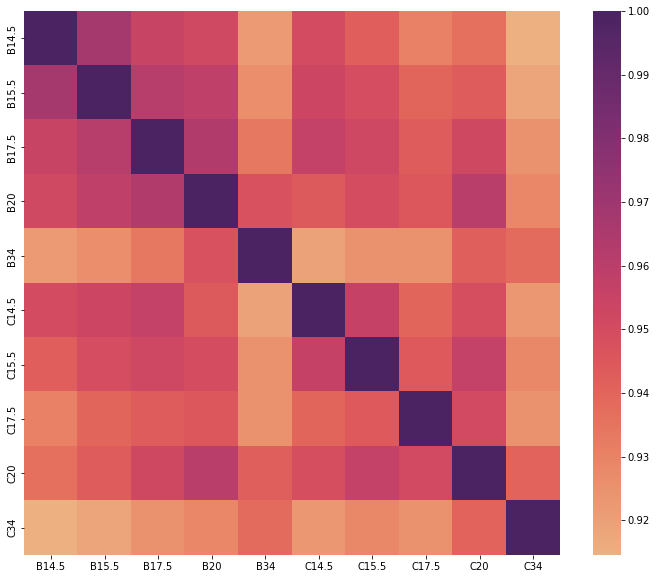

In [ ]:
# Heatmap
counts = pd.DataFrame(counts, columns=my_samples)
corr_matrix = counts.corr(method='spearman')
plt.figure(figsize=(12,10))
cmap = sns.cm.flare
sns.heatmap(corr_matrix, cmap=cmap)

* Явно разделяются образцы взрослых мышей и мышей в возрасте 20 и менее дней.
* Образцы мышей одного возраста коррелируют лучше, чем разного.
* Образцы одного отдела мозга также коррелируют между собой лучше, чем с другим отделом (В/В и С/С).

In [ ]:
# PCA
corr_matrix_arr = np.array(corr_matrix)
dist_matrix = 1 - corr_matrix_arr
dist_matrix = pd.DataFrame(dist_matrix, columns=my_samples, index=my_samples)
dist_matrix

,B14.5,B15.5,B17.5,B20,B34,C14.5,C15.5,C17.5,C20,C34
B14.5,0.000000,0.032670,0.045304,0.048445,0.077943,0.049549,0.057814,0.069332,0.063703,0.085448
B15.5,0.032670,0.000000,0.038878,0.041561,0.073524,0.046672,0.050721,0.059805,0.056548,0.081551
B17.5,0.045304,0.038878,0.000000,0.036532,0.065937,0.043409,0.047504,0.056421,0.048007,0.074638
B20,0.048445,0.041561,0.036532,0.000000,0.052331,0.055856,0.050359,0.054858,0.039780,0.071307
B34,0.077943,0.073524,0.065937,0.052331,0.000000,0.080654,0.074703,0.074444,0.057727,0.061840
C14.5,0.049549,0.046672,0.043409,0.055856,0.080654,0.000000,0.043846,0.060069,0.050959,0.076781
C15.5,0.057814,0.050721,0.047504,0.050359,0.074703,0.043846,0.000000,0.055409,0.043678,0.071595
C17.5,0.069332,0.059805,0.056421,0.054858,0.074444,0.060069,0.055409,0.000000,0.049279,0.074969
C20,0.063703,0.056548,0.048007,0.039780,0.057727,0.050959,0.043678,0.049279,0.000000,0.059172
C34,0.085448,0.081551,0.074638,0.071307,0.061840,0.076781,0.071595,0.074969,0.059172,0.000000


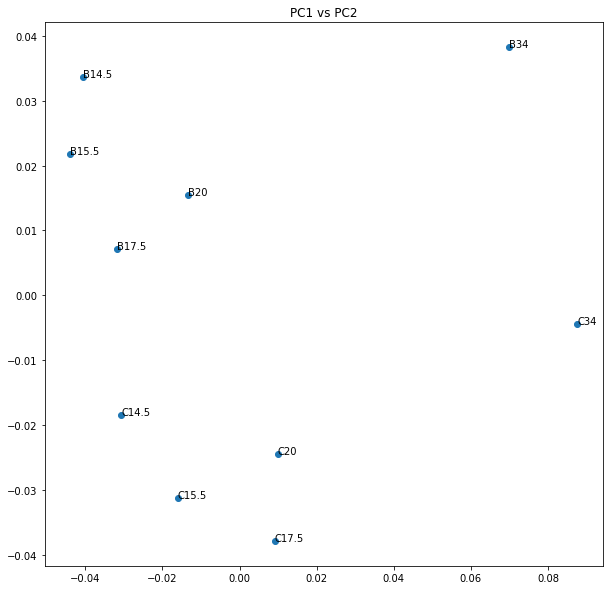

In [ ]:
pca = PCA(n_components=10)
pca.fit(dist_matrix)
data_pca = pca.transform(dist_matrix)

plt.figure(figsize=(10,10))
plt.scatter(data_pca[:, 0], data_pca[:, 1], cmap='viridis')
plt.title('PC1 vs PC2')
for i in range(len(data_pca)):
    plt.annotate(my_samples[i], (data_pca[i, 0], data_pca[i, 1]))
plt.show()

* Хорошо разделяются образцы взрослых мышей (34 дня) и юных.
* Образцы разных отделов мозга хорошо кластеризуются между собой. То есть на экспрессию влияет в основном тот факт, взрослая ли мышь, а также ткань, из которой был взят образец.